Let's now make the same analysis but with transforming the numeric data to normal distributions.

Below is the code on Python with notes and corresponding graphs for the analysis.

Let's first import libraries and make some configurations and data cleanup for further analysis.

In [7]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn import preprocessing

import datetime
import wordcloud
import json

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.options.display.float_format = "{:.2f}".format

In [3]:
plot_colors = ["#d92027", "#ff9234", "#ffcd3c", "#35d0ba"]

In [26]:
# Create your connection.
cnx = sqlite3.connect('youtubeus.db')
df = pd.read_sql_query("SELECT * FROM video_first_trending_date", cnx)

## Univeriate analysis

Let's create some useful columns for further analysis and transform data to normal distributions (because our data looked pretty much as logarithmic distributions).

In [67]:
df["description"] = df["description"].fillna(value="")
df["dislikes_likes_ratio"] = df["dislikes"].div(df["likes"])*100
df = df.replace(np.inf, 1)
df["dislikes_likes_ratio"] = df["dislikes_likes_ratio"].fillna(value=0)
df['views'] = np.log(df['views']+1)
df['likes'] = np.log(df['likes']+1)
df['dislikes'] = np.log(df['dislikes']+1)
df['comment_count'] = np.log(df['comment_count']+1)

### Describtion of numerical columns
Let's see statistical information about the new numerical values.

In [64]:
df[['views','likes','dislikes','comment_count']].describe()

views   likes  dislikes  comment_count
count 6351.00 6351.00   6351.00        6351.00
mean    12.46    8.75      5.51           6.66
std      1.80    2.27      1.99           2.17
min      6.31    0.00      0.00           0.00
25%     11.40    7.60      4.34           5.61
50%     12.61    9.05      5.62           6.88
75%     13.67   10.24      6.80           8.01
max     19.21   15.54     13.35          14.02

## Bivariate Analysis

Let's see the scatter plots and histograms of all the numeric variables, including new ones.

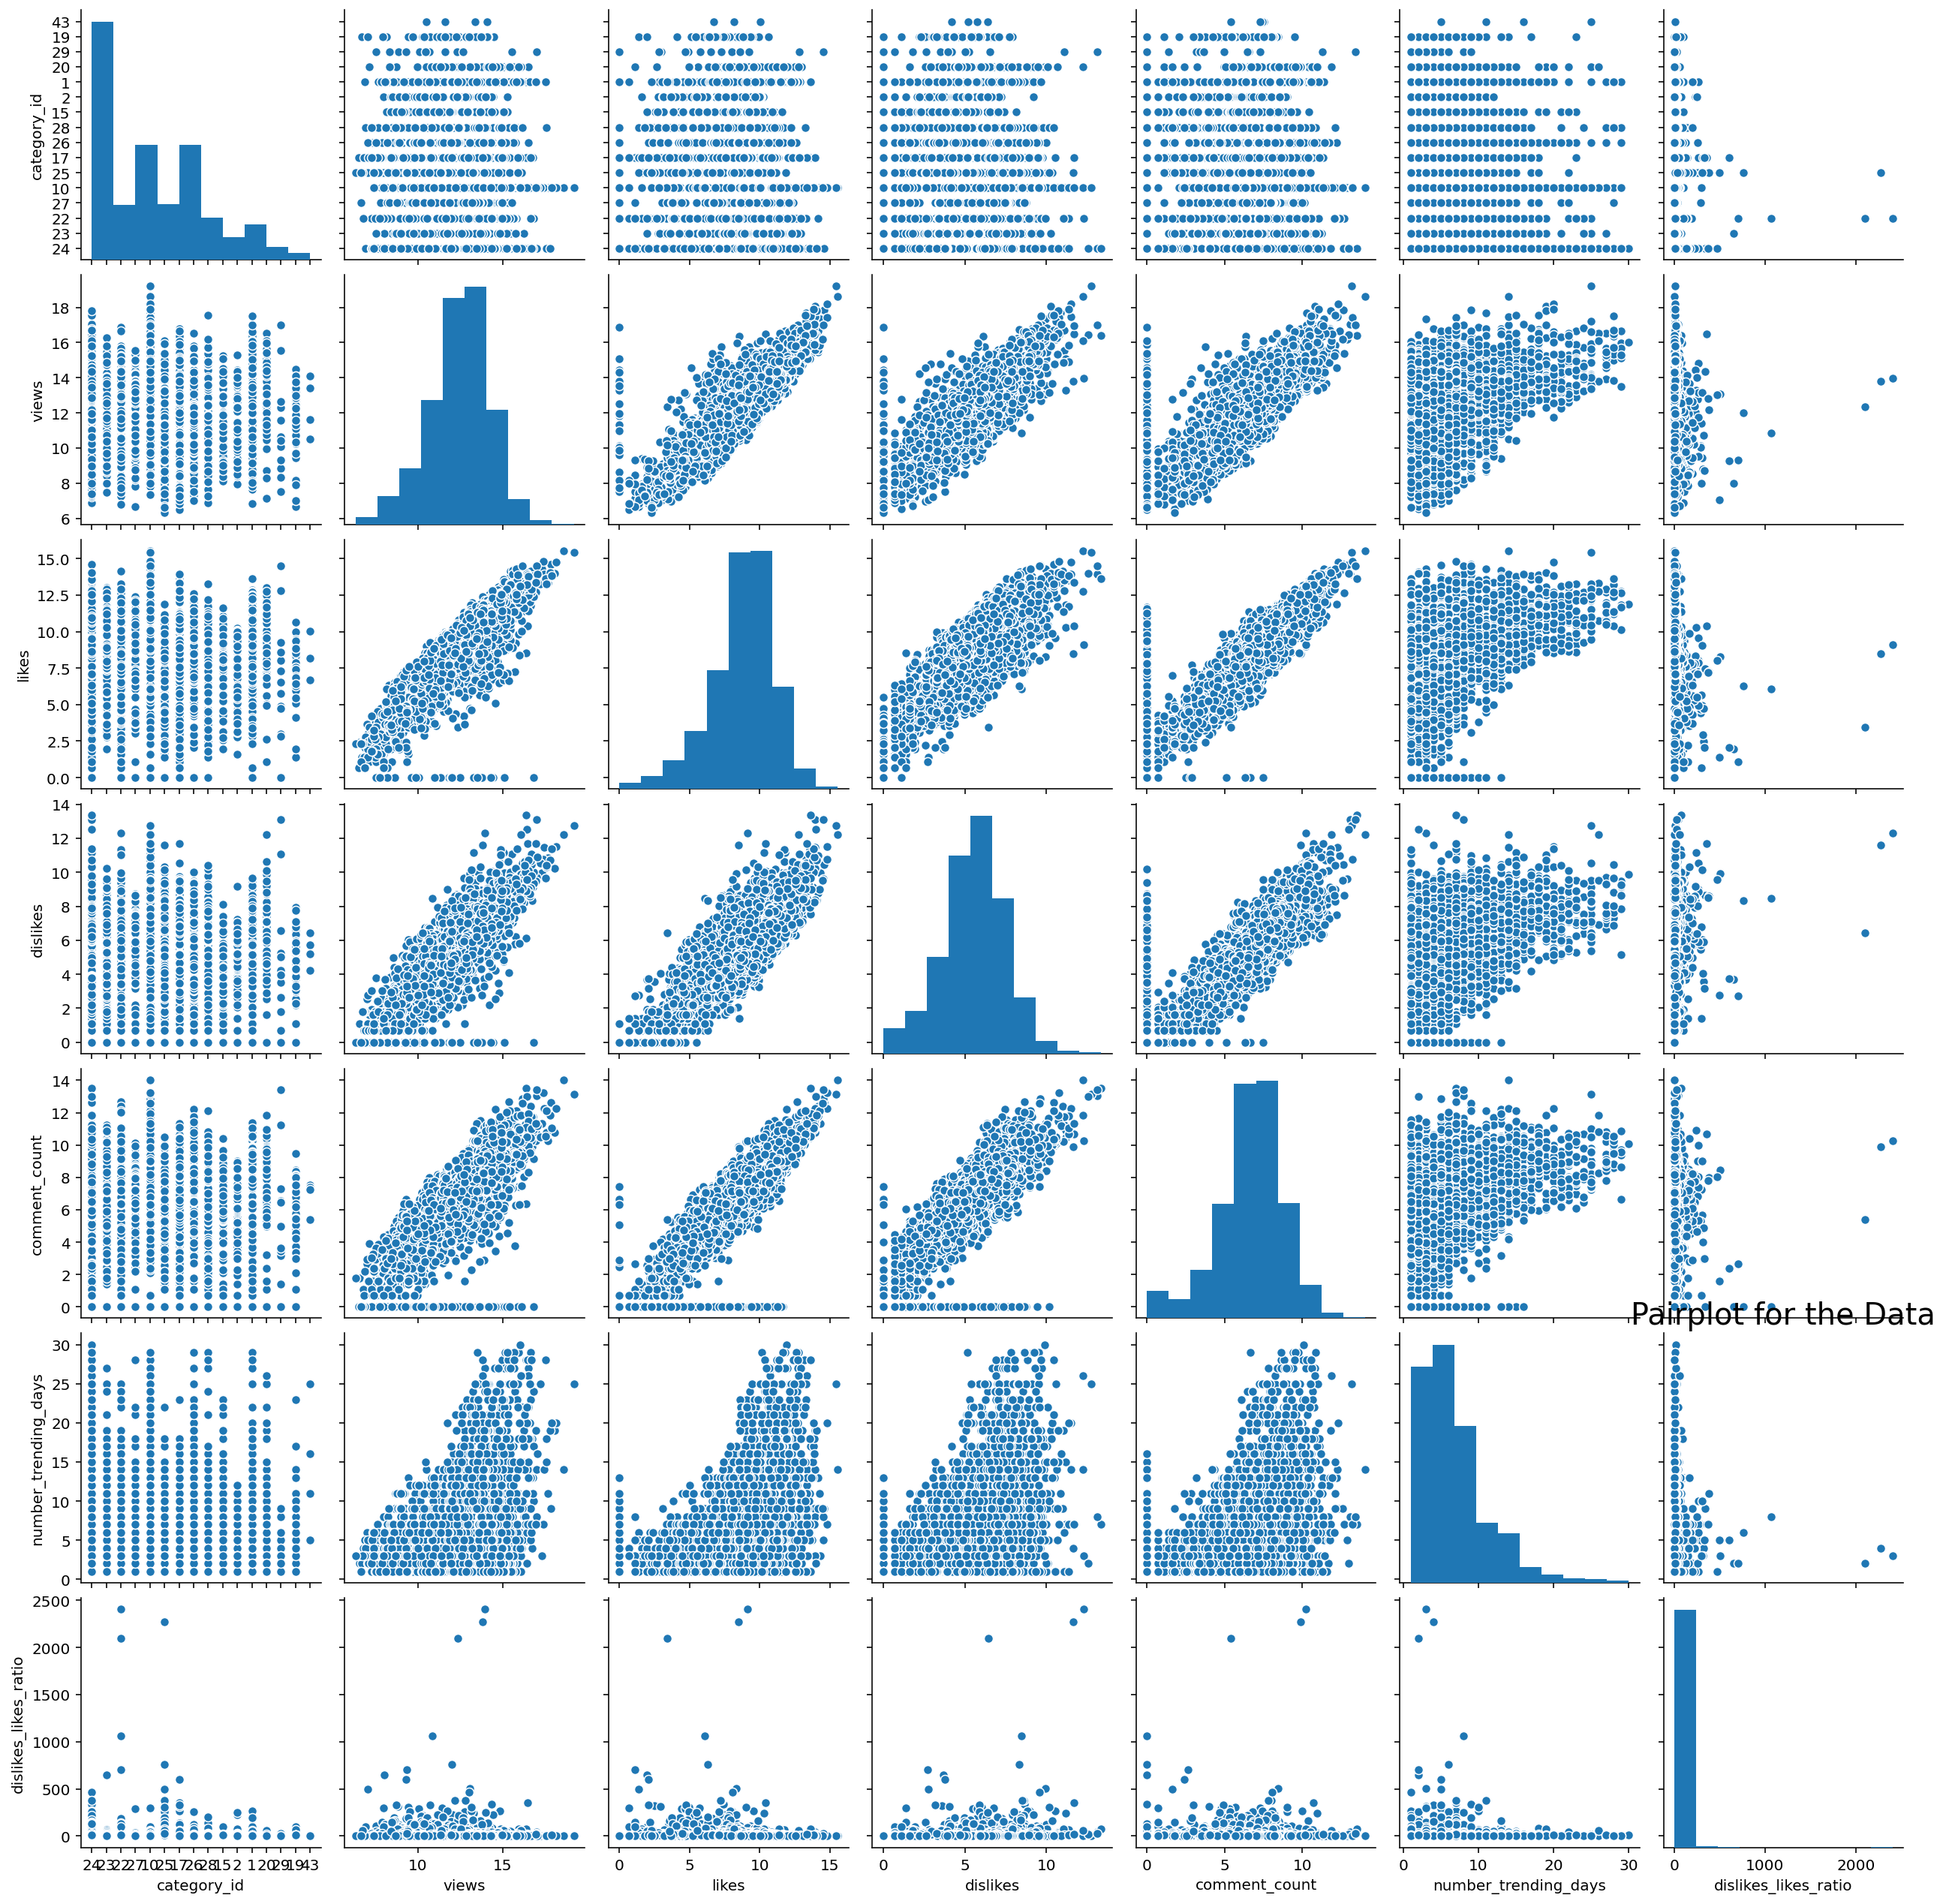

In [29]:
sns.pairplot(df)
plt.title('Pairplot for the Data', fontsize = 20)
plt.show()

Now we can see that the histograms of views/likes/dislikes/comment_count look more like normal distributions. Now let's look at the correlations coefficients.

Let's make a heatmap of the correlation

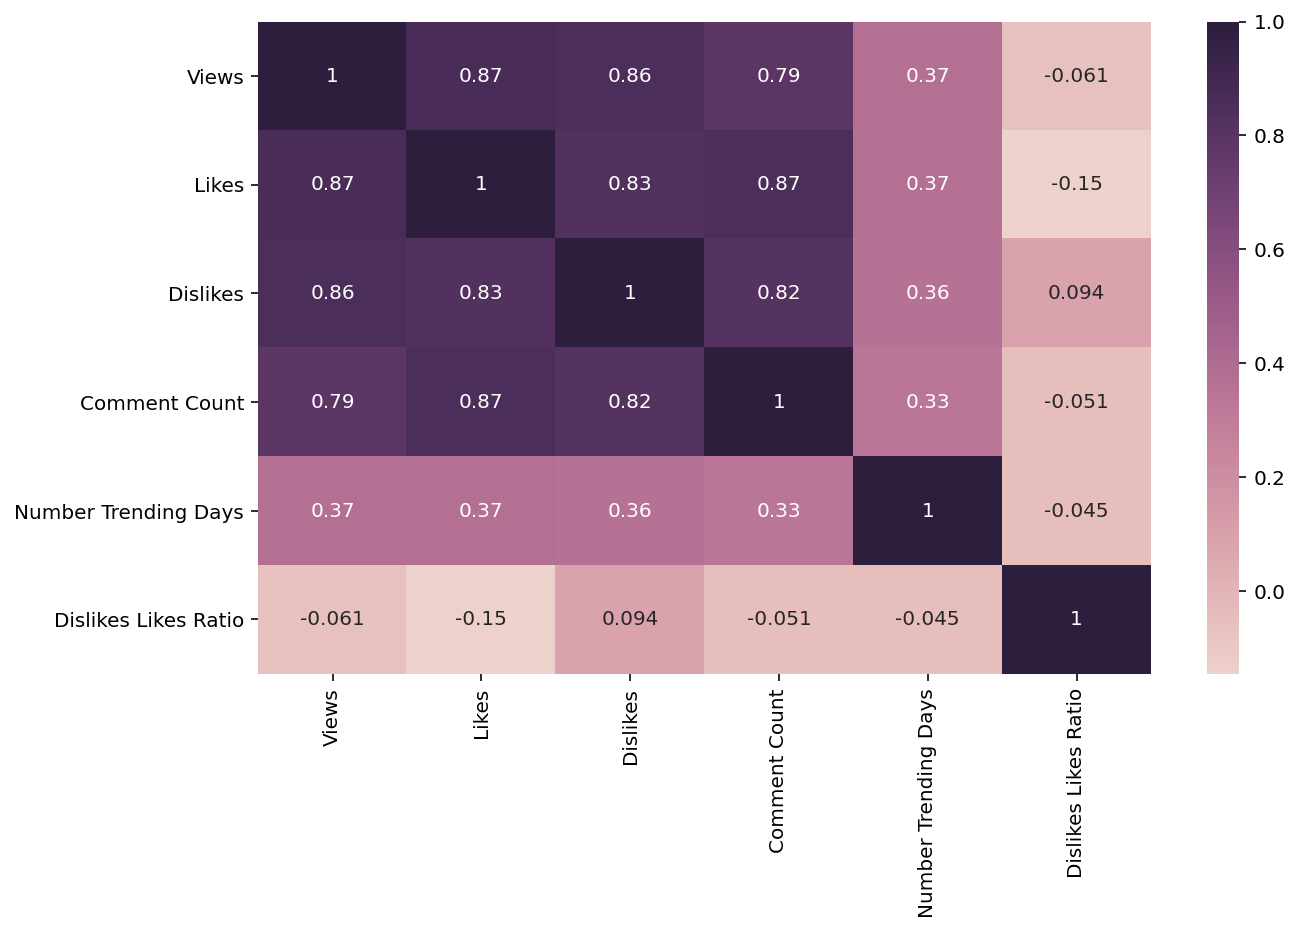

In [32]:
h_labels = [x.replace('_', ' ').title() for x in
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

We can see that likes/views, likes/comment_count, dislikes/comment_count are still correlated. But what is more, likes/dislikes, views/dislikes started to be correlated as well.

Let's have a closer look at the views/likes.

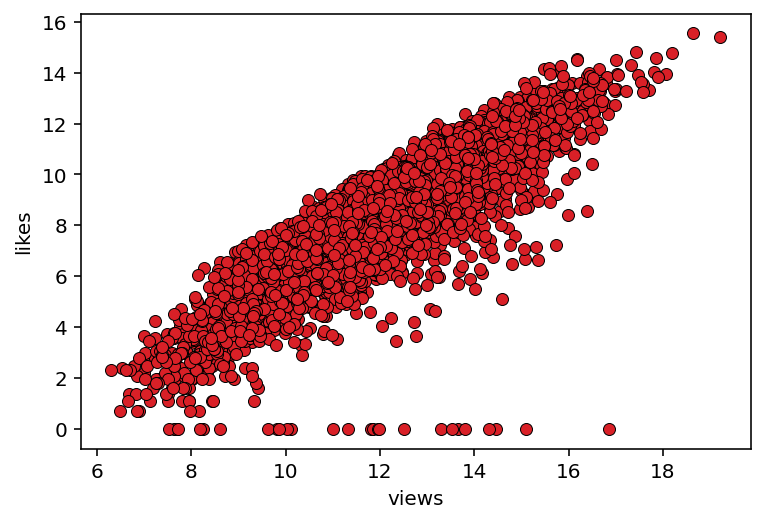

In [30]:
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color=plot_colors[0], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="views", ylabel="likes")

## Cluster Analysis

### Hierarchical Clustering
Let's make a hierarchical clustering for views.

Text(0, 0.5, 'Ecuclidean Distance')

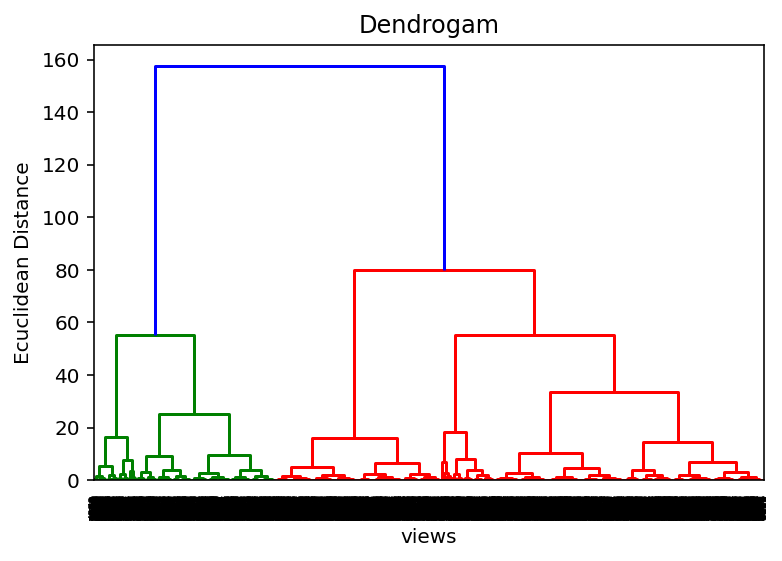

In [47]:
dendrogram = sch.dendrogram(sch.linkage(df[['views']], method = 'ward'))
plt.title('Dendrogam')
plt.xlabel('views')
plt.ylabel('Ecuclidean Distance')

For views 3 might be an optimal # clusters.

Let's make a hierarchical clustering for likes.

Text(0, 0.5, 'Ecuclidean Distance')

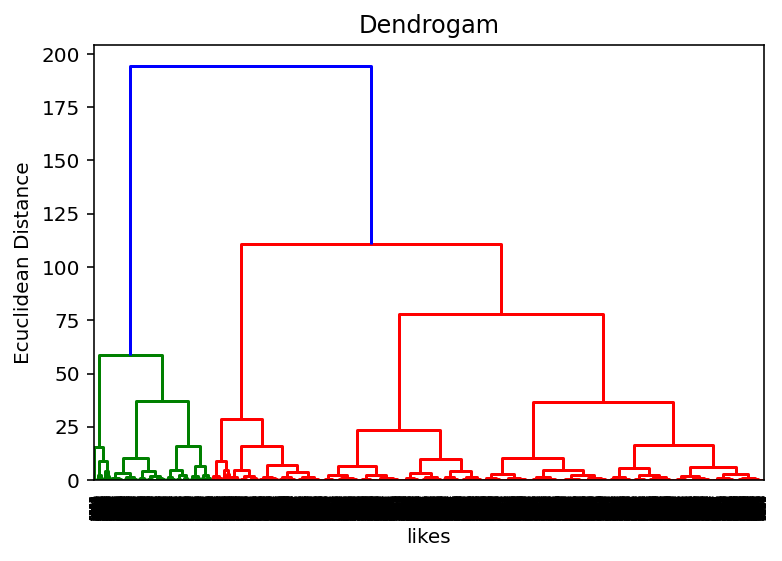

In [48]:
dendrogram = sch.dendrogram(sch.linkage(df[['likes']], method = 'ward'))
plt.title('Dendrogam')
plt.xlabel('likes')
plt.ylabel('Ecuclidean Distance')

For likes 3 might be an optimal # clusters.

### K-Means

Let's find clusters for the number of trending dates and views values.

First, let's make the Elbow Method to find the number of optimal clusters.

Text(0, 0.5, 'wcss')

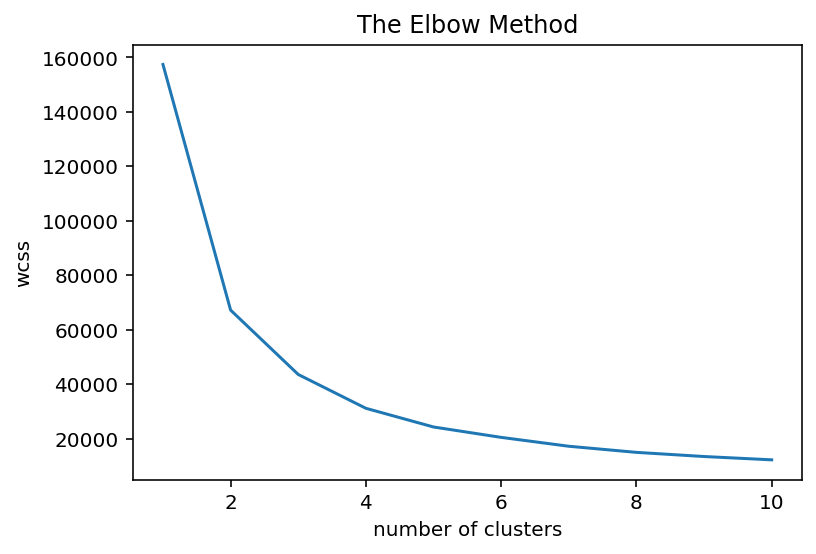

In [60]:
x = df[['number_trending_days','views']]
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')

Let's choose 2 as number of clusters.

Text(0, 0.5, 'views')

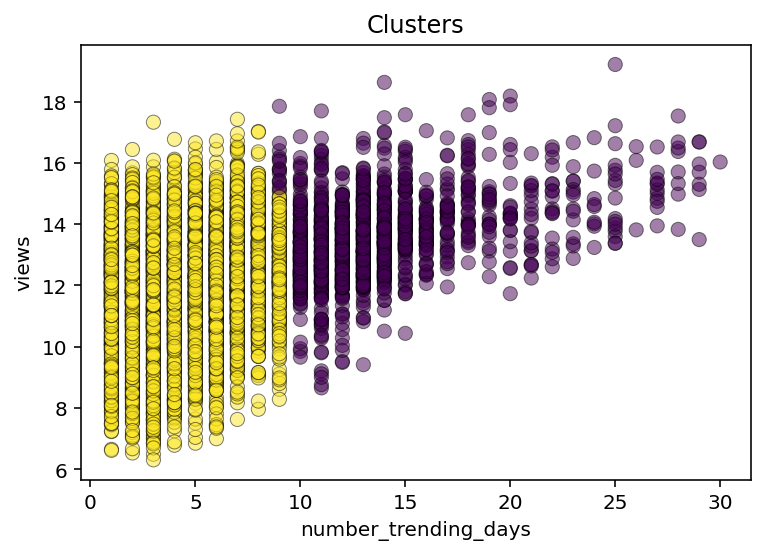

In [62]:
y_means = KMeans(n_clusters = 2, init = 'k-means++', max_iter=300, random_state = 0).fit_predict(x)
plt.scatter(x['number_trending_days'], x['views'], c = y_means, s = 50, alpha=0.5, edgecolors="#000000", linewidths=0.5)
plt.title('Clusters')
plt.xlabel('number_trending_days')
plt.ylabel('views')

Let's find 3 dimensional clusters.

First, for views/likes/dislikes.

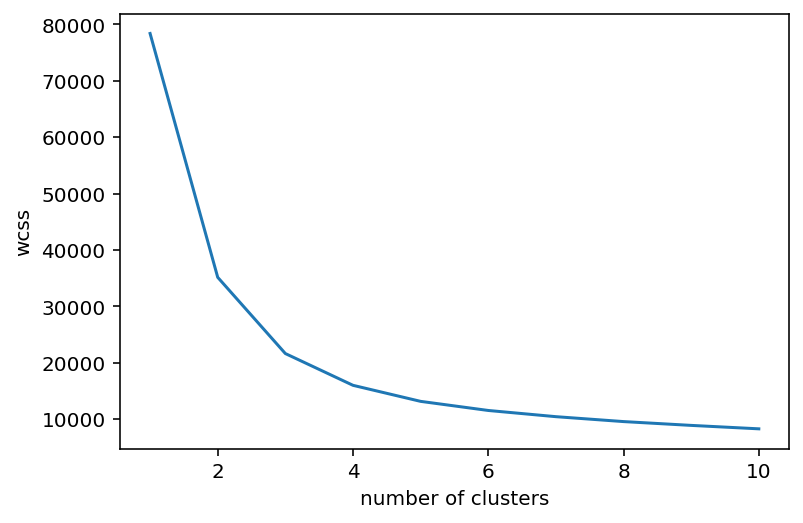

In [35]:
x = df[['views', 'likes', 'dislikes']]

wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss)
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

Let's choose 3 as number of clusters.

In [40]:
model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

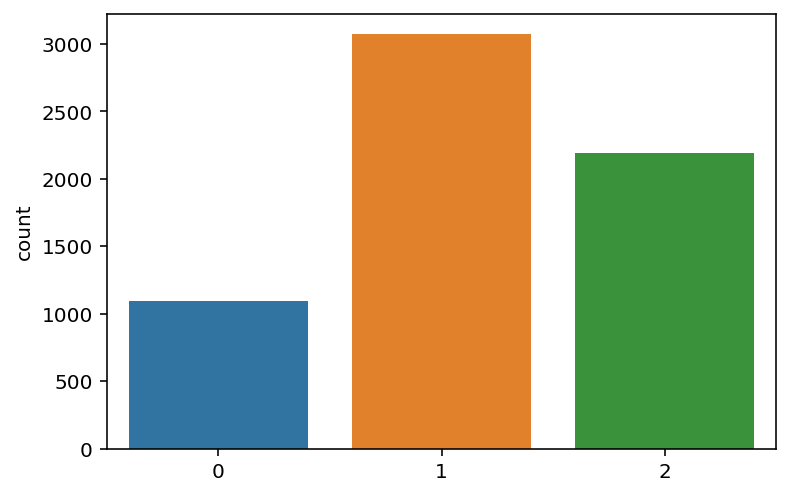

In [41]:
sns.countplot(y_clusters)

Text(0.5, 0, 'dislikes')

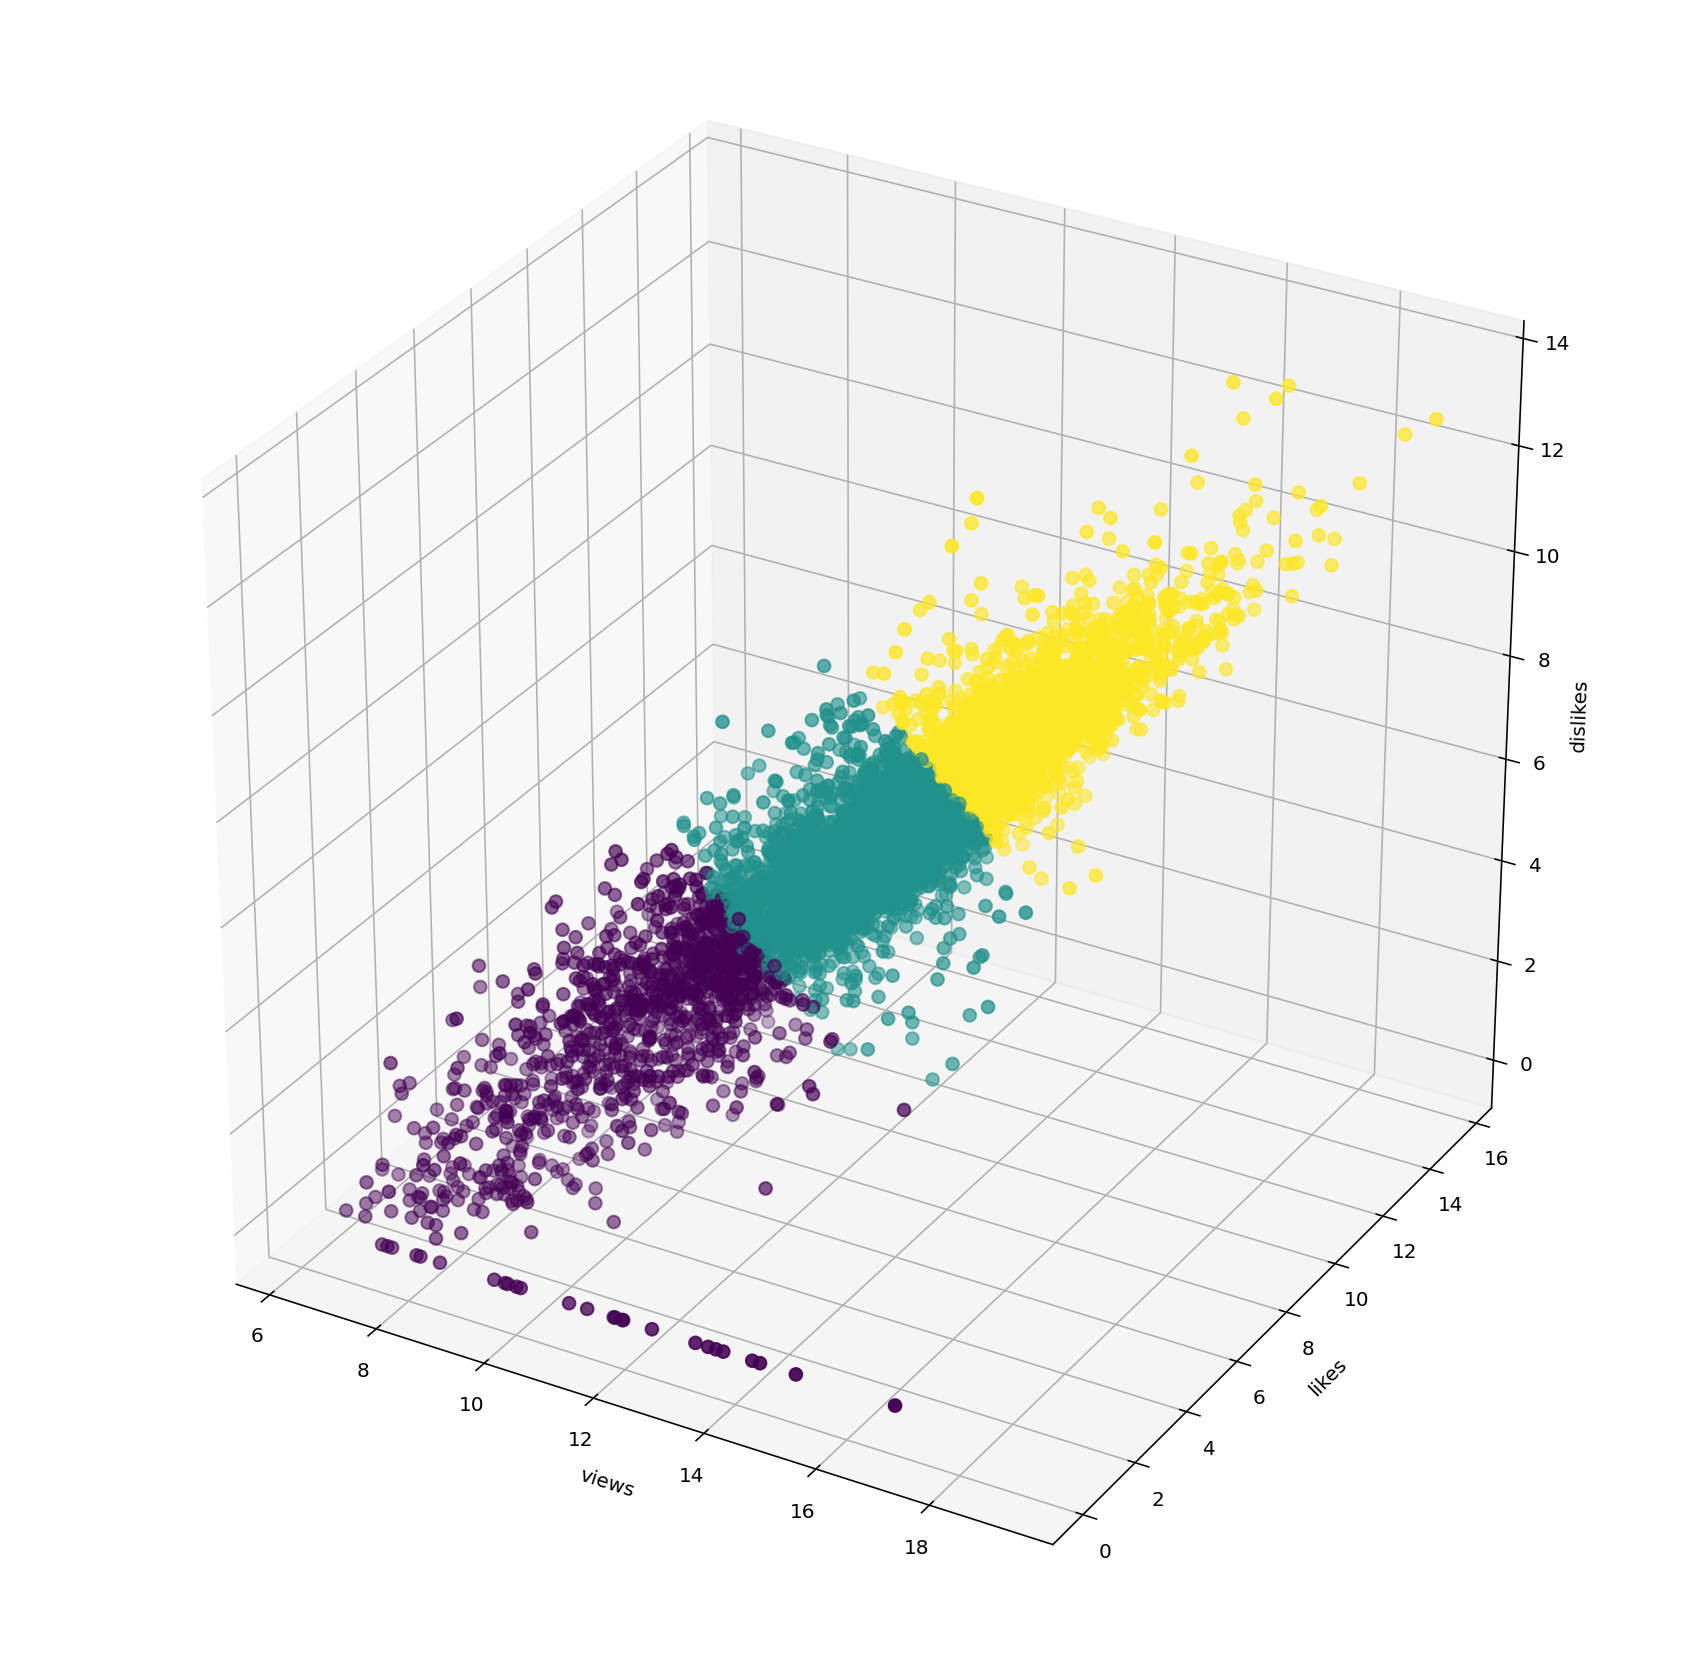

In [42]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x['views'],x['likes'],x['dislikes'], s = 40 , c = y_clusters)
ax.set_xlabel('views')
ax.set_ylabel('likes')
ax.set_zlabel('dislikes')


Now for views/dislikes_likes_ratio/number_trending_days

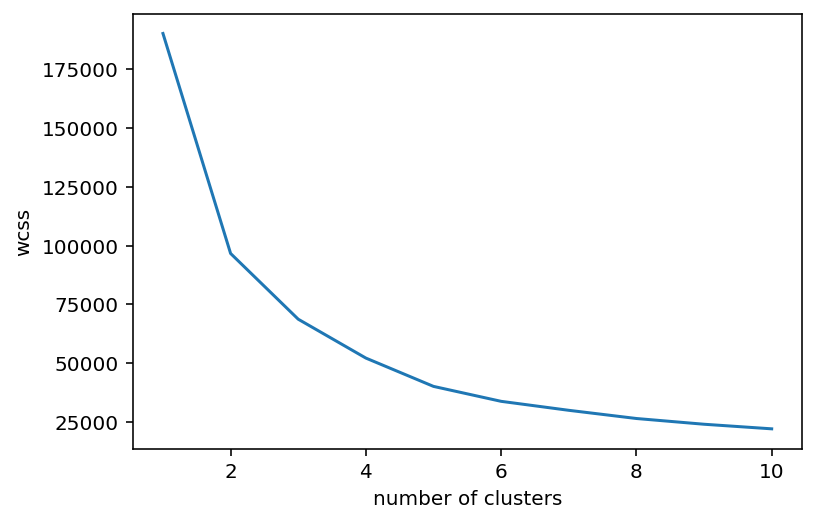

In [49]:
x = df[['views', 'likes', 'number_trending_days']]

wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss)
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

Let's choose 3 as number of clusters.

In [57]:
model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

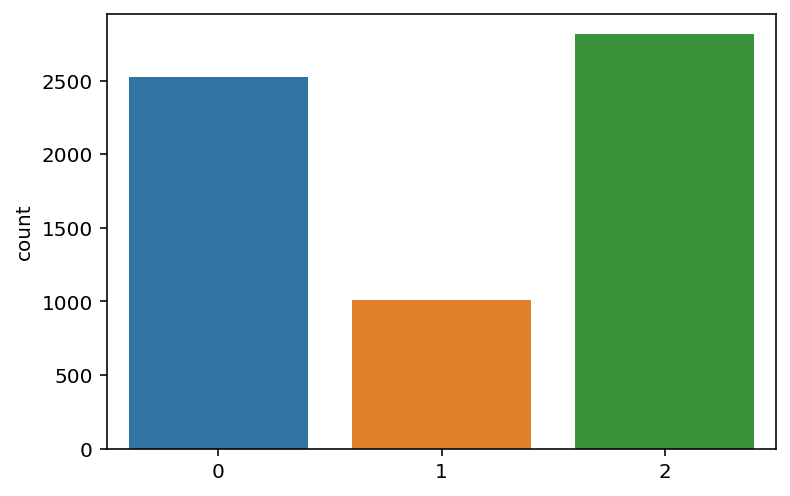

In [58]:
sns.countplot(y_clusters)

Text(0.5, 0, 'number_trending_days')

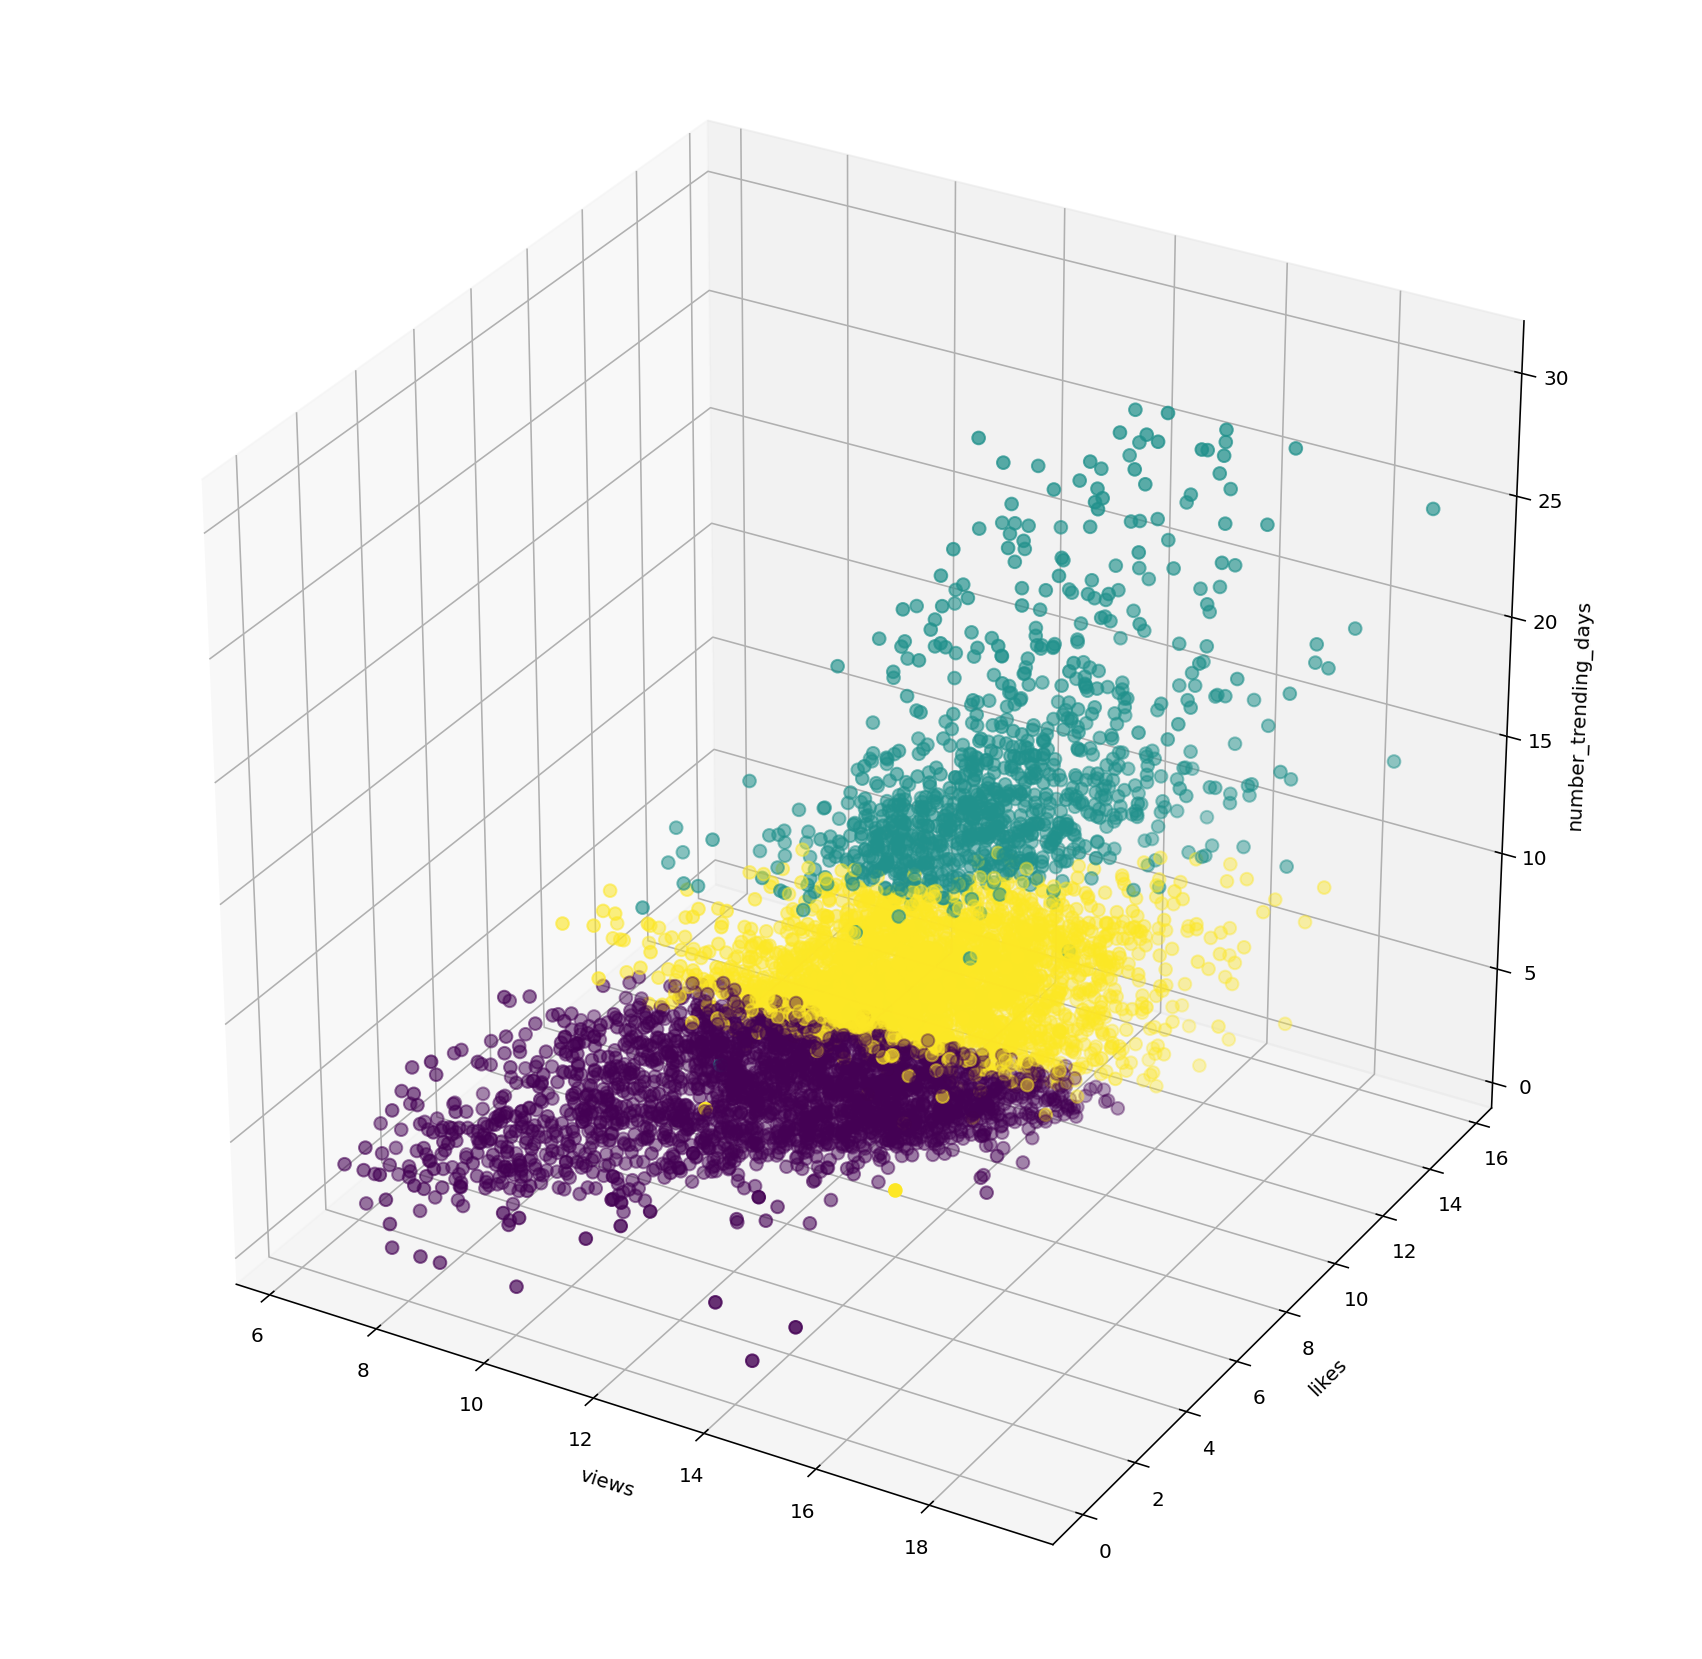

In [59]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x['views'],x['likes'],x['number_trending_days'], s = 40 , c = y_clusters)
ax.set_xlabel('views')
ax.set_ylabel('likes')
ax.set_zlabel('number_trending_days')


We can say that:

- 1 cluster (green) is "super popular" videos which have a high number of trending days, likes, views.
- 2 cluster (yellow) is "popular" videos which have a medium number of trending days, likes, views.
- 3 cluster (purple) is "not so popular" videos which have lower number of trending days, likes, views.